In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pip install scikit-optimize

In [0]:
%matplotlib inline 

import pylab as plt

import pandas as pd
import numpy as np

import collections

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import itertools
 
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize, forest_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

from sklearn.model_selection import train_test_split

from sklearn.externals import joblib

from sklearn.metrics import confusion_matrix

In [0]:
full_train = pd.read_csv('/data/Features_train3.csv')
full_train.head()

,Unnamed: 0,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",...,__freq_signif_ratio_21___3_,__freq_signif_ratio_21___4_,__freq_signif_ratio_21___5_,__freq_signif_ratio_31___0_,__freq_signif_ratio_31___1_,__freq_signif_ratio_31___2_,__freq_signif_ratio_31___3_,__freq_signif_ratio_31___4_,__freq_signif_ratio_31___5_,__freq_varrat___0_,__freq_varrat___1_,__freq_varrat___2_,__freq_varrat___3_,__freq_varrat___4_,__freq_varrat___5_,__freq_y_offset___0_,__freq_y_offset___1_,__freq_y_offset___2_,__freq_y_offset___3_,__freq_y_offset___4_,__freq_y_offset___5_,time_score,phase_score,ddf_bool,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,0,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835268,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,-327.742307,1761.066406,-14.306331,-5.373326,205.036926,1628.427737,-1.475181,0.128917,22370.594834,2806.374162,-1.255123,0.415580,7780.500807,2805.598113,-1.409885,0.339918,7024.003068,2536.068846,-1.449858,0.293128,3245.366349,2741.539785,...,0.919127,0.936241,0.980085,0.750430,0.798199,0.734428,0.731502,0.628905,0.915124,0.127550,0.269031,0.139362,0.110785,0.129578,0.401664,4.173310,-29.908400,18.747900,17.090800,20.412000,12.103300,0.197098,0.934001,1,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,1,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,-4.884564,29.506064,-20.730002,-6.040676,190.427851,299.586559,-1.014003,0.260052,57.109047,192.539229,-1.097170,-0.087865,44.477327,191.057528,-1.188472,-0.022678,55.270113,212.522263,-1.142896,-0.167176,50.414646,203.892482,...,0.911566,0.942109,0.914162,0.834175,0.880634,0.801262,0.745575,0.866079,0.908687,0.113341,0.076214,0.086381,0.111883,0.166179,0.369518,0.535781,-0.255908,0.167986,0.680787,-0.218376,0.177517,0.778523,-0.130853,1,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,2,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,25.373110,66.469870,29.315018,2.619697,3.461790,4.729538,0.474215,0.356910,7.334944,13.515895,0.976374,0.471342,124.845250,119.500254,5.131290,2.385066,168.280524,162.799417,7.125665,2.662075,219.745132,202.532898,...,0.947548,1.026690,0.959602,0.969243,0.903630,0.820510,0.868992,0.920047,0.935167,0.758565,0.657343,0.204607,0.292954,0.318256,0.500549,-0.003923,0.211586,4.263530,5.710620,5.226490,-0.328019,0.481251,0.419737,1,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,3,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,152.835617,236.289675,26.521968,1.546038,129.421659,123.298327,4.629801,2.023211,320.174052,280.440312,50.868880,7.007099,543.845781,491.548270,36.088137,5.688194,807.123762,710.721942,16.392533,3.751

In [0]:
full_train = full_train.replace([np.inf, -np.inf], np.nan)

In [0]:
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

In [0]:
np.any(full_train.isna())

False

In [0]:
np.any(np.isinf(full_train))

False

In [0]:
print(full_train.shape)
full_train.head()


(7848, 368)


,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,...,__freq_signif_ratio_21___2_,__freq_signif_ratio_21___3_,__freq_signif_ratio_21___4_,__freq_signif_ratio_21___5_,__freq_signif_ratio_31___0_,__freq_signif_ratio_31___1_,__freq_signif_ratio_31___2_,__freq_signif_ratio_31___3_,__freq_signif_ratio_31___4_,__freq_signif_ratio_31___5_,__freq_varrat___0_,__freq_varrat___1_,__freq_varrat___2_,__freq_varrat___3_,__freq_varrat___4_,__freq_varrat___5_,__freq_y_offset___0_,__freq_y_offset___1_,__freq_y_offset___2_,__freq_y_offset___3_,__freq_y_offset___4_,__freq_y_offset___5_,time_score,phase_score,ddf_bool,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835268,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,-327.742307,1761.066406,-14.306331,-5.373326,205.036926,1628.427737,-1.475181,0.128917,22370.594834,2806.374162,-1.255123,0.415580,7780.500807,2805.598113,-1.409885,0.339918,7024.003068,2536.068846,-1.449858,0.293128,3245.366349,2741.539785,-1.548319,...,0.910704,0.919127,0.936241,0.980085,0.750430,0.798199,0.734428,0.731502,0.628905,0.915124,0.127550,0.269031,0.139362,0.110785,0.129578,0.401664,4.173310,-29.908400,18.747900,17.090800,20.412000,12.103300,0.197098,0.934001,1,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,-4.884564,29.506064,-20.730002,-6.040676,190.427851,299.586559,-1.014003,0.260052,57.109047,192.539229,-1.097170,-0.087865,44.477327,191.057528,-1.188472,-0.022678,55.270113,212.522263,-1.142896,-0.167176,50.414646,203.892482,-1.190245,...,0.895489,0.911566,0.942109,0.914162,0.834175,0.880634,0.801262,0.745575,0.866079,0.908687,0.113341,0.076214,0.086381,0.111883,0.166179,0.369518,0.535781,-0.255908,0.167986,0.680787,-0.218376,0.177517,0.778523,-0.130853,1,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,25.373110,66.469870,29.315018,2.619697,3.461790,4.729538,0.474215,0.356910,7.334944,13.515895,0.976374,0.471342,124.845250,119.500254,5.131290,2.385066,168.280524,162.799417,7.125665,2.662075,219.745132,202.532898,6.081065,...,1.021410,0.947548,1.026690,0.959602,0.969243,0.903630,0.820510,0.868992,0.920047,0.935167,0.758565,0.657343,0.204607,0.292954,0.318256,0.500549,-0.003923,0.211586,4.263530,5.710620,5.226490,-0.328019,0.481251,0.419737,1,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,152.835617,236.289675,26.521968,1.546038,129.421659,123.298327,4.629801,2.023211,320.174052,280.440312,50.868880,7.007099,543.845781,491.548270,

In [0]:
y = full_train['target']
y.head()

0    92
1    88
2    42
3    90
4    90
Name: target, dtype: int64

In [0]:
y_t = full_train['true_target']
y_t.head()

0    92
1    88
2    42
3    90
4    90
Name: true_target, dtype: int64

In [0]:
full_train = full_train.drop(['target','true_target','Unnamed: 0'],axis=1)
full_train

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,...,__freq_signif_ratio_21___2_,__freq_signif_ratio_21___3_,__freq_signif_ratio_21___4_,__freq_signif_ratio_21___5_,__freq_signif_ratio_31___0_,__freq_signif_ratio_31___1_,__freq_signif_ratio_31___2_,__freq_signif_ratio_31___3_,__freq_signif_ratio_31___4_,__freq_signif_ratio_31___5_,__freq_varrat___0_,__freq_varrat___1_,__freq_varrat___2_,__freq_varrat___3_,__freq_varrat___4_,__freq_varrat___5_,__freq_y_offset___0_,__freq_y_offset___1_,__freq_y_offset___2_,__freq_y_offset___3_,__freq_y_offset___4_,__freq_y_offset___5_,time_score,phase_score,ddf_bool,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835268,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,-327.742307,1761.066406,-14.306331,-5.373326,205.036926,1628.427737,-1.475181,0.128917,22370.594834,2806.374162,-1.255123,0.415580,7780.500807,2805.598113,-1.409885,0.339918,7024.003068,2536.068846,-1.449858,0.293128,3245.366349,2741.539785,-1.548319,...,0.910704,0.919127,0.936241,0.980085,0.750430,0.798199,0.734428,0.731502,0.628905,0.915124,0.127550,0.269031,0.139362,0.110785,0.129578,0.401664,4.173310e+00,-2.990840e+01,1.874790e+01,1.709080e+01,2.041200e+01,12.103300,0.197098,0.934001,1,1,0.000,0.000,0.000,0.0,0.0,0.000,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,-4.884564,29.506064,-20.730002,-6.040676,190.427851,299.586559,-1.014003,0.260052,57.109047,192.539229,-1.097170,-0.087865,44.477327,191.057528,-1.188472,-0.022678,55.270113,212.522263,-1.142896,-0.167176,50.414646,203.892482,-1.190245,...,0.895489,0.911566,0.942109,0.914162,0.834175,0.880634,0.801262,0.745575,0.866079,0.908687,0.113341,0.076214,0.086381,0.111883,0.166179,0.369518,5.357810e-01,-2.559080e-01,1.679860e-01,6.807870e-01,-2.183760e-01,0.177517,0.778523,-0.130853,1,1,1.817,45.703,0.000,0.0,0.0,0.000,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,25.373110,66.469870,29.315018,2.619697,3.461790,4.729538,0.474215,0.356910,7.334944,13.515895,0.976374,0.471342,124.845250,119.500254,5.131290,2.385066,168.280524,162.799417,7.125665,2.662075,219.745132,202.532898,6.081065,...,1.021410,0.947548,1.026690,0.959602,0.969243,0.903630,0.820510,0.868992,0.920047,0.935167,0.758565,0.657343,0.204607,0.292954,0.318256,0.500549,-3.923360e-03,2.115860e-01,4.263530e+00,5.710620e+00,5.226490e+00,-0.328019,0.481251,0.419737,1,2,0.233,40.328,0.004,4.5,0.0,0.000,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,152.835617,236.289675,26.521968,1.546038,129.421659,123.298327,4.629801,2.023211,3

In [0]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    
    y_ohe = pd.get_dummies(y_true)
    
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    
    y_p_log = np.log(y_p)

    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)

    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


In [0]:
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


In [0]:
x = full_train

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [0]:
print(type(x_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [0]:
x_train.head()

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,...,__freq_signif_ratio_21___2_,__freq_signif_ratio_21___3_,__freq_signif_ratio_21___4_,__freq_signif_ratio_21___5_,__freq_signif_ratio_31___0_,__freq_signif_ratio_31___1_,__freq_signif_ratio_31___2_,__freq_signif_ratio_31___3_,__freq_signif_ratio_31___4_,__freq_signif_ratio_31___5_,__freq_varrat___0_,__freq_varrat___1_,__freq_varrat___2_,__freq_varrat___3_,__freq_varrat___4_,__freq_varrat___5_,__freq_y_offset___0_,__freq_y_offset___1_,__freq_y_offset___2_,__freq_y_offset___3_,__freq_y_offset___4_,__freq_y_offset___5_,time_score,phase_score,ddf_bool,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
3780,-44.372135,651.572510,55.980248,6.708821,141.827748,3.080023,1.580938,67.597649,11.971041,8.723506,11.076282,2.053868,0.122807,36562.076689,5.560579,1.886061e+07,5.550901,515.851695,695.944645,12.431968,1.349118,18.784217,9.675712,-1.117121,0.502323,422.291985,397.874840,10.982367,3.312967,43.451495,50.935582,3.003605,-1.022783,1972.634958,1794.215904,2.475548,2.046282,2525.342274,2100.313374,3.265492,...,0.943527,1.007120,0.917869,1.027790,1.041170,0.989583,0.916115,1.006720,0.910730,1.028940,0.699481,0.425463,0.348365,0.306471,0.389895,0.610647,0.029886,9.413680,0.598230,5.451140,-0.151086,0.781144,0.260091,0.011656,0,1,1.521,45.223,0.041,-339.8,3.1,0.070,59716.398,8430,0.0,0.0,0.0,0.0,0.0,0.0
1468,-16.653620,39.460102,1.964313,0.342631,7.552441,2.660028,0.692048,11.262239,2.463291,1.973097,1.718646,1.825871,0.066667,4835.719343,5.331704,1.161478e+05,6.346740,24.018716,56.113722,28.566586,2.336250,25.340307,16.204792,-0.461515,-0.135520,26.370730,2.210139,1.774940,0.852013,102.691818,93.213046,6.854908,2.650090,169.467295,162.708615,5.557660,2.577184,171.712134,166.424507,3.394333,...,0.908838,0.981927,0.969340,1.062270,0.907294,0.852918,0.904029,0.943573,0.953903,0.982249,0.675432,0.472694,0.248544,0.309505,0.355186,0.523498,0.003252,0.229342,1.764980,2.588710,-1.007830,0.800686,0.528790,0.375474,1,1,0.694,43.123,-0.006,-296.2,0.0,0.000,60628.340,28,0.0,0.0,0.0,0.0,0.0,0.0
5787,-69.962029,334.430878,37.544389,5.985272,86.949806,2.093396,3.921939,71.993958,16.141280,12.179266,12.132685,1.731553,0.166667,4609.811161,3.338782,1.037068e+06,4.006532,224.969745,404.392907,10.771061,1.797544,88.119484,192.642251,0.728135,1.243782,347.471672,325.696102,2.387719,1.896523,927.375021,760.788751,2.169817,1.758038,710.164017,668.244926,1.531199,1.704065,982.495940,968.547404,3.220195,...,0.966523,1.021660,0.999856,1.056660,1.079310,1.060590,0.933428,1.021240,1.010470,1.056630,0.598854,0.825789,0.542110,0.451528,0.632875,0.116320,-0.053779,2.525440,4.050990,1.341450,0.634973,-0.140143,0.654729,0.002094,0,1,1.593,45.351,0.017,120.2,3.1,0.052,60555.734,36459,0.0,0.0,0.0,0.0,0.0,0.0
5818,-65.753746,84.185013,4.903786,2.959215,18.654567,0.694285,1.298308,55.660557,11.531109,6.976273,11.003805,1.576512,0.036364,487.068581,4.999308,1.024441e+04,6.638136,21.032786,149.938759,30.576122,7.128811,22.565330,29.462833,0.656870,0.043165,18.498589,14.873031,1.797662,1.137212,94.454195,56.653043,1.102670,1.321688,123.219119,88.435541

In [0]:
y_train.head()

3780    95
1468    90
5787    95
5818    90
5501    65
Name: target, dtype: int64

In [0]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)   #33-67
clfs = []
importances = pd.DataFrame()

In [0]:
classes = np.unique(y)
classes

array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95])

In [0]:
dim_learning_rate = Real(low=1e-6, high=1e-1, prior='log-uniform',name='learning_rate')
dim_estimators = Integer(low=50, high=2000,name='n_estimators')
dim_max_depth = Integer(low=1, high=6,name='max_depth')

dimensions = [dim_learning_rate,
              dim_estimators,
              dim_max_depth]

default_parameters = [0.03,1000,3]

In [0]:

oof_preds = np.zeros((len(full_train), len(classes)))
oof_preds.shape    

(7848, 14)

In [0]:

print(folds.split(y_train, y_train))

<generator object _BaseKFold.split at 0x7f044a1f0e60>


In [0]:
for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
    print(fold_)
    print((trn_, val_))

0
(array([   0,    1,    2, ..., 5489, 5491, 5492]), array([   7,   11,   13, ..., 5478, 5482, 5490]))
1
(array([   0,    2,    3, ..., 5489, 5490, 5491]), array([   1,   12,   15, ..., 5480, 5488, 5492]))
2
(array([   0,    1,    2, ..., 5488, 5490, 5492]), array([   6,   10,   18, ..., 5483, 5489, 5491]))
3
(array([   0,    1,    2, ..., 5490, 5491, 5492]), array([   3,    4,    8, ..., 5484, 5485, 5487]))
4
(array([   1,    3,    4, ..., 5490, 5491, 5492]), array([   0,    2,    5, ..., 5479, 5481, 5486]))


In [0]:


def createModel(learning_rate,n_estimators,max_depth):       

    oof_preds = np.zeros((len(x_train), len(classes)))
    for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
        trn_x, trn_y = x_train.iloc[trn_], y_train.iloc[trn_]
        val_x, val_y = x_train.iloc[val_], y_train.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params,learning_rate=learning_rate,
                                n_estimators=n_estimators,max_depth=max_depth)
        
        
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=False,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        print('fold',fold_+1,multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        clfs.append(clf)
        
    
    
    loss = multi_weighted_logloss(y_true=y_train, y_preds=oof_preds)
    print('MULTI WEIGHTED LOG LOSS : %.5f ' % loss)
    
    return loss



In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate,n_estimators,max_depth):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    n_estimators:      Number of estimators.
    max_depth:         Maximum Depth of tree.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.2e}'.format(learning_rate))
    print('estimators:', n_estimators)
    print('max depth:', max_depth)
    
    lv= createModel(learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    max_depth = max_depth)
    return lv


In [0]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'subsample': .9,
    'colsample_bytree': .7,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'silent':True,
    'verbosity':-1,
    'nthread':-1
}

In [0]:
%%time

error = fitness(default_parameters)

learning rate: 3.00e-02
estimators: 1000
max depth: 3
fold 1 0.6425455985767154
fold 2 0.6784283945594305
fold 3 0.5892790284513368
fold 4 0.5765837578480498
fold 5 0.6392524771828318
MULTI WEIGHTED LOG LOSS : 16.27109 
CPU times: user 7min 48s, sys: 1.77 s, total: 7min 50s
Wall time: 3min 57s


In [0]:
%%time
# use only if you haven't found out the optimal parameters for xgb. else comment this block.
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=20,
                           x0=default_parameters)

learning rate: 3.00e-02
estimators: 1000
max depth: 3
fold 1 0.6425455985767154
fold 2 0.6784283945594305
fold 3 0.5892790284513368
fold 4 0.5765837578480498
fold 5 0.6392524771828318
MULTI WEIGHTED LOG LOSS : 16.27109 
learning rate: 8.59e-03
estimators: 971
max depth: 4
fold 1 0.6682915404584687
fold 2 0.7156796087885302
fold 3 0.6159810495051462
fold 4 0.6098760695780308
fold 5 0.6479164403734342
MULTI WEIGHTED LOG LOSS : 15.97305 
learning rate: 5.49e-03
estimators: 567
max depth: 4
fold 1 0.8984682399335967
fold 2 0.9089930199644543
fold 3 0.8353168567456398
fold 4 0.8661397214975447
fold 5 0.839406998627714
MULTI WEIGHTED LOG LOSS : 14.89373 
learning rate: 1.37e-06
estimators: 1910
max depth: 5
fold 1 3.2264714075039325
fold 2 3.2214289887546705
fold 3 3.2215323756460603
fold 4 3.2221658088207854
fold 5 3.2208727272903
MULTI WEIGHTED LOG LOSS : 14.01655 
learning rate: 8.47e-04
estimators: 1731
max depth: 6
fold 1 1.291112202448839
fold 2 1.3261171980699085
fold 3 1.255834543333

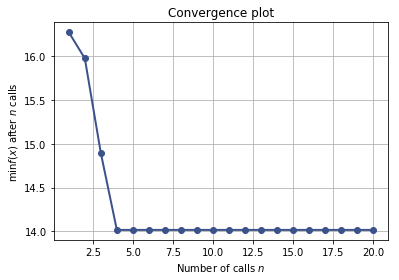

In [0]:
plot_convergence(search_result)
plt.show()

In [0]:
# optimal parameters found using scikit optimize. use these parameter to initialize the 2nd level model.
print(search_result.x)
learning_rate = search_result.x[0]
n_estimators = search_result.x[1]
max_depth = search_result.x[2]


[1e-06, 2000, 6]


In [0]:
joblib.dump(fitness(search_result.x),'model1')

learning rate: 1.00e-06
estimators: 2000
max depth: 6
fold 1 3.2288050844648954
fold 2 3.223743650803912
fold 3 3.2238118123106845
fold 4 3.2243336971207426
fold 5 3.2232056060098215
MULTI WEIGHTED LOG LOSS : 14.01654 


['model1']

In [0]:
oof_preds = np.zeros((len(x_train), len(classes)))
for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
    trn_x, trn_y = x_train.iloc[trn_], y_train.iloc[trn_]
    val_x, val_y = x_train.iloc[val_], y_train.iloc[val_]
    
    clf = lgb.LGBMClassifier(**lgb_params,learning_rate=learning_rate,
                                n_estimators=n_estimators,max_depth=max_depth)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50
    )



    
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y_train, y_preds=oof_preds))


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 2.17801	training's wloss: 3.23602	valid_1's multi_logloss: 2.18326	valid_1's wloss: 3.23603
[200]	training's multi_logloss: 2.17772	training's wloss: 3.23563	valid_1's multi_logloss: 2.18297	valid_1's wloss: 3.23565
[300]	training's multi_logloss: 2.17743	training's wloss: 3.23524	valid_1's multi_logloss: 2.18268	valid_1's wloss: 3.23527
[400]	training's multi_logloss: 2.17714	training's wloss: 3.23484	valid_1's multi_logloss: 2.1824	valid_1's wloss: 3.23489
[500]	training's multi_logloss: 2.17684	training's wloss: 3.23445	valid_1's multi_logloss: 2.18211	valid_1's wloss: 3.23451
[600]	training's multi_logloss: 2.17655	training's wloss: 3.23406	valid_1's multi_logloss: 2.18182	valid_1's wloss: 3.23412
[700]	training's multi_logloss: 2.17626	training's wloss: 3.23367	valid_1's multi_logloss: 2.18154	valid_1's wloss: 3.23374
[800]	training's multi_logloss: 2.17597	training's wloss: 3.23328	valid

In [0]:
print(oof_preds.shape)
oof_preds

(5493, 14)


array([[0.01998626, 0.06398918, 0.11719229, ..., 0.29151546, 0.03293162,
        0.02119324],
       [0.02000108, 0.06386462, 0.11703859, ..., 0.2926482 , 0.03295586,
        0.02068632],
       [0.01998969, 0.06409101, 0.11719908, ..., 0.29159873, 0.03293707,
        0.02119685],
       ...,
       [0.02002725, 0.06371726, 0.11718665, ..., 0.29186101, 0.03277   ,
        0.02070908],
       [0.02000947, 0.06482626, 0.1170877 , ..., 0.29162965, 0.03296969,
        0.02073824],
       [0.0200285 , 0.0639324 , 0.11717927, ..., 0.29178815, 0.03306277,
        0.02070364]])

In [0]:
preds = None
for clf in clfs:
    if preds is None:
        preds = clf.predict_proba(x_test[x_train.columns]) / folds.n_splits
    else:
        preds += clf.predict_proba(x_test[x_train.columns]) / folds.n_splits
    

    
# Store predictions
preds_df = pd.DataFrame(preds, columns=['class_' + str(s) for s in clfs[0].classes_])



In [0]:
preds_df.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,0.366226,1.152894,2.113507,3.377467,0.494663,0.055671,1.207042,0.248145,2.277524,0.539952,0.848320,10.345795,0.595843,0.376949
1,0.390856,1.128790,8.186988,2.705496,0.383868,0.061947,1.136992,0.242239,2.353371,0.485941,0.845137,5.126058,0.584044,0.368274
2,0.364109,1.160633,2.108871,3.258163,0.461987,0.058608,1.272895,0.247610,2.258288,0.558386,0.843536,10.435124,0.595140,0.376649
3,0.364183,1.146510,2.099537,3.273400,0.489255,0.054995,1.224650,0.323610,2.248761,0.607763,0.895370,10.298748,0.592717,0.380501
4,0.369697,1.169984,2.129861,3.439644,0.829519,0.063432,1.638839,0.251289,2.281039,0.583995,0.868904,9.388225,0.602625,0.382946


In [0]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
y_test.head()

4325    90
2166    16
4270    90
1905    90
1454    52
Name: target, dtype: int64

In [0]:
preds.shape

(2355, 14)

In [0]:
y_d = pd.get_dummies(y_test)
print(y_d.shape)
y_d.values

(2355, 14)


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_d.values,axis=-1), np.argmax(preds,axis=-1))
np.set_printoptions(precision=2)


Normalized confusion matrix
[[0.83 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.17 0.   0.  ]
 [0.   0.9  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.  ]
 [0.   0.   0.   0.52 0.   0.   0.   0.   0.   0.   0.   0.48 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.01 0.   0.   0.63 0.   0.   0.   0.   0.35 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.15 0.   0.   0.   0.85 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.9  0.1  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.05 0.93 0.  ]
 [0.   0.   0.   0.   0

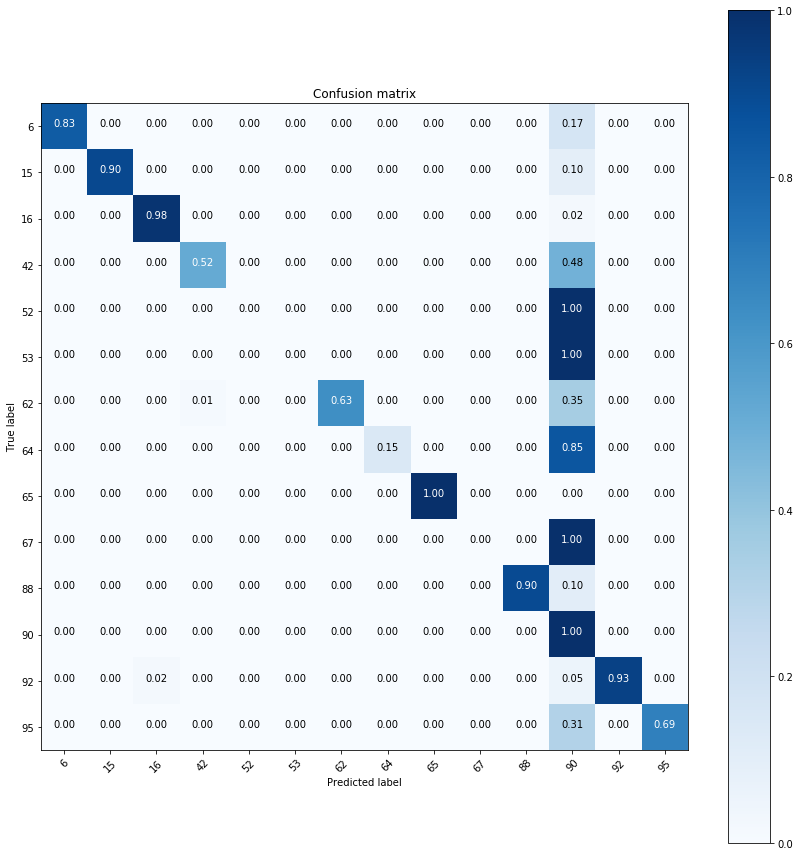

In [0]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes,normalize=True,
                      title='Confusion matrix')
